(chap_imagej_colors)=
# ImageJ: Channels & colors

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

ImageJ has good support for both RGB and multichannel images, but the behavior is not always obvious.
This section explains the ideas, including common areas of confusion.


## RGB vs. Multichannel

ImageJ treats RGB as a special image type, even though it is still [8-bit unsigned integer](chap_bit_depths_imagej).
There are several ways to recognize that an image has the type 'RGB':
* The text *RGB* appears at the top of the image window
* {menuselection}`Image --> Type --> RGB Color` is selected
* When moving the cursor over the image, there are *three* values shown in the status bar (e.g. *value=127,127,127*) instead of one

Multichannel images that *aren't* RGB are recognizable because they have an extra slider at the bottom, with a small {guilabel}`C` label, which is used to switch the 'active' channel.
The {menuselection}`Image --> Type --> ` will be {menuselection}`8-bit`, {menuselection}`16-bit` or {menuselection}`32-bit`.

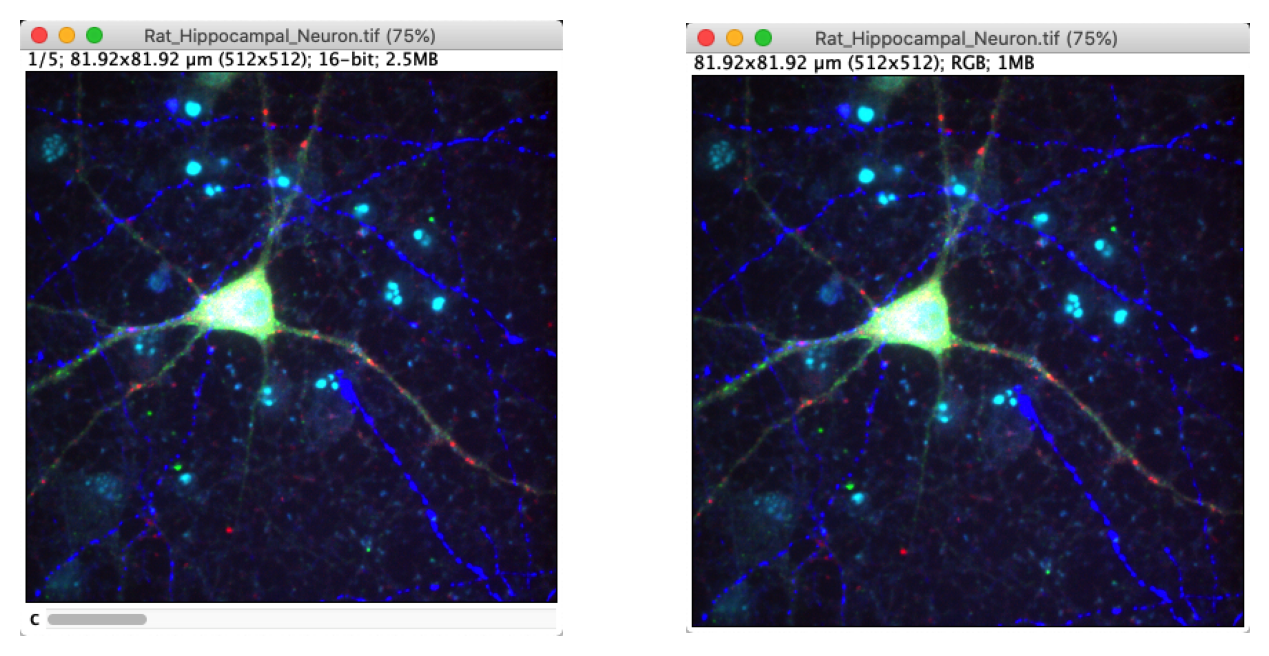

In [2]:
fig = create_figure(figsize=(8, 4))
show_image('images/neuron-composite.png', pos=121)
show_image('images/neuron-rgb.png', pos=122)
glue_fig('fig_color_neuron', fig)

```{glue:figure} fig_color_neuron
---
align: center
name: fig-color_neuron
---
A multichannel image (left) and RGB image (right).
The colors used to display the image are identical, but other aspects of the image window indicate that the images themselves are quite different.
```

The distinction is really important when it comes to measurements and histograms, because the behavior between RGB and multichannel images is subtly different:

* **Multichannel images:**
  * {menuselection}`Analyze --> Measure` uses the active channel only, based on the {guilabel}`C` slider
  * {menuselection}`Analyze --> Histogram` uses either uses the active channel only or all channels, after prompting the user to choose
  * {menuselection}`Image --> Adjust --> Brightness/Contrast...` can be used to adjust the brightness & contrast for the active channel
  * It is possible to change LUTs independently for each channel
* **RGB images:**
  * {menuselection}`Analyze --> Measure` converts the image to have a single 8-bit channel before making measurements
  * {menuselection}`Analyze --> Histogram` creates a histogram after converting the image as above, but also provides an {guilabel}`RGB` button to also view separate histograms for the red, green and blue channels
  * {menuselection}`Image --> Adjust --> Brightness/Contrast...` can only be used to adjust the brightness & contrast for all channels simultaneously
  * It is *not* possible to change LUTs per channel

When it comes to measuring an RGB image, the enigmatic statement above that ImageJ 'converts the image' is explained (in more detail than you might want) [at the end](sec_colors_converts).

````{tab-set}

```{tab-item} Practical


Explore several of the images under {menuselection}`File --> Open Samples -->` and identify which are treated by ImageJ as RGB, which as multichannel, and which have just a single channel.
There is only one correct answer per image.

**Note 1:** Here, 'RGB' means that ImageJ treats the image has having the special 'RGB' image type.
It's possible for a multichannel image to have three channels with red, green and blue LUTs, but Imagej doesn't consider it to be RGB.
You should therefore use the rules given above to distinguish images RGB from multichannel.

**Note 2:** At the time I write this, the sample images don't work for me properly in Fiji -- but they do work in ImageJ.
Hopefully the Fiji bug will be fixed before you read this.

| Image                                    | RGB | Multichannel | Single channel |
|------------------------------------------|:---:|:------------:|:--------------:|
|{menuselection}`Leaf`                     |  ?  |      ?       |       ?        |
|{menuselection}`Fluorescent Cells`        |  ?  |      ?       |       ?        |
|{menuselection}`Cardio (RGB Dicom)`       |  ?  |      ?       |       ?        |
|{menuselection}`HeLa Cells (48-bit RGB)`  |  ?  |      ?       |       ?        |
|{menuselection}`Fly Brain`                |  ?  |      ?       |       ?        |
|{menuselection}`Image with Overlay`       |  ?  |      ?       |       ?        |

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/launch-imagej-js-badge.svg)](https://ij.imjoy.io)

```


```{tab-item} Solution

| Image                                    | RGB | Multichannel | Single channel |
|------------------------------------------|:---:|:------------:|:--------------:|
|{menuselection}`Leaf`                     |  X  |              |                |
|{menuselection}`Fluorescent Cells`        |     |      X       |                |
|{menuselection}`Cardio (RGB Dicom)`       |  X  |              |                |
|{menuselection}`HeLa Cells (48-bit RGB)`  |     |      X       |                |
|{menuselection}`Fly Brain`                |  X  |              |                |
|{menuselection}`Image with Overlay`       |     |              |    X           |


There are several awkward images:

* {menuselection}`HeLa Cells (48-bit RGB)` is *not* treated as having the RGB type... and ImageJ doesn't have a '48-bit' type either! Here, 48-bit RGB means that we actually have three 16-bit channels with red, green and blue LUTs. For ImageJ, that's not really an RGB image, it's a multichannel image. Don't expect too much consistency in naming: always check the types!
* {menuselection}`Fly Brain` has a slider, but it doesn't have a {guilabel}`C` label. This is because the slider isn't for channels, but rather for *z*-slices. We will meet *z*-slices in the [next chapter](chap_dimensions).
* {menuselection}`Image with Overlay` looks colorful, but the colors all come from the [overlay](sec_imagej_overlay) -- not from the image being RGB. Admittedly, the name helps here.

```

````


## Working with channels

There are several useful commands for working with color channels under {menuselection}`Image --> Color --> `.
Some of these, such as {menuselection}`Image --> Color --> Split channels` and {menuselection}`Image --> Color --> Merge channels` are quite intuitive, and work for both RGB and multichannel images.

One of the most useful commands that requires some explanation is {menuselection}`Image --> Color --> Channels Tool...` {kbd}`Shift+Z`.
If you run the {menuselection}`Channels Tool...` command for an RGB image and try to do anything, ImageJ will ask

<img src="./images/channels-tool-composite.png" align="center" />

Agreeing to the prompt will convert the RGB image to a multichannel image.

The question might be a little bit confusing because 'composite' and 'multichannel' do not quite mean the same thing, although they are sometimes used interchangeably with ImageJ.
To be more precise, a 'composite image' in this context is a multichannel image that is displayed using a particular **display mode**.

ImageJ has three main modes for displaying multichannel images, accessible from the drop-down menu of the *Channels Tool* dialog:
* {guilabel}`Composite` -- Merge some or all the channels together for display. Currently, this works with up to 7 or 8 channels (depending on software version; an extra one was added recently). Individual channels can be turned on and off.
* {guilabel}`Color` -- View the 'active' channel only, using its original color LUT. You can switch the channel with the slider below the image.
* {guilabel}`Grayscale` -- Similar to {guilabel}`Color`, except always using a grayscale LUT.

Whenever a channel is active, the LUT can be changed using options in the *Channels Tool* dialog -- or the {menuselection}`Image --> Lookup Tables --> ` submenu as usual.
Similarly, {menuselection}`Image --> Adjust --> Brightness/Contrast...` works on the active channel to update the LUT.

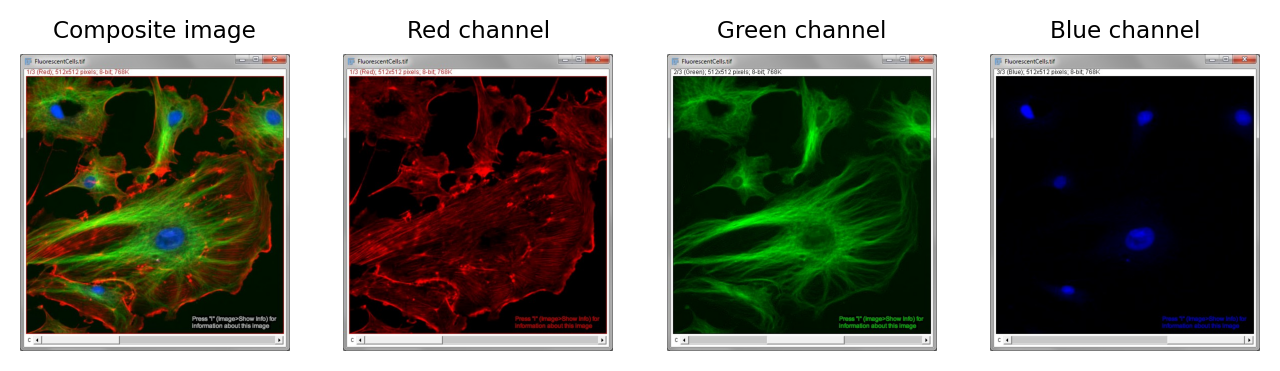

In [3]:
fig = create_figure(figsize=(8, 4))
show_image('images/composite_all.jpg', title='Composite image', pos=141)
show_image('images/composite_red.jpg', title='Red channel', pos=142)
show_image('images/composite_green.jpg', title='Green channel', pos=143)
show_image('images/composite_blue.jpg', title='Blue channel', pos=144)
glue_fig('fig_color_composite', fig)

```{glue:figure} fig_color_composite
---
align: center
name: fig-fiji_composite
---

ImageJ multichannel image sample *Fluorescent Cells*. Using the {menuselection}`Image --> Color --> Channels Tool...` and the slider at the bottom of the window, you can view the channels individually or simultaneously.
```

The way in which {guilabel}`Composite` mode works is that an RGB image is effectively created for each channel based on its LUT, and the red, green and blue values are *added* together to get the final output color (clipping at 255 if needed).

This isn't the only way to generate a composite image, and it doesn't work well for all LUTs -- particular LUTs that map low pixel values to bright colors or white.

Therefore, since ImageJ 1.53o some additional composite modes were added to the {menuselection}`Channels Tool...`, and refined over the next few releases after a long (and occasionally testy) discussion on image.sc.
At the time of writing, the available modes are:
* {guilabel}`Composite Max` -- Similar to {guilabel}`Composite`, except use the *maximum* of the red, green and blue values across all channels (not the sum)
* {guilabel}`Composite Min` -- Similar to {guilabel}`Composite Max`, except use the *minimum* of the red, green and blue values across all channels (not the maximum)
* {guilabel}`Composite Invert` -- Similar to {guilabel}`Composite`, except *subtract* the red, green and blue LUT values instead of adding them

Both {guilabel}`Composite Min` and {guilabel}`Composite Invert` are useful for LUTs with light backgrounds, therefore if you select one of these options ImageJ may flip a LUT to have a light background if needed.

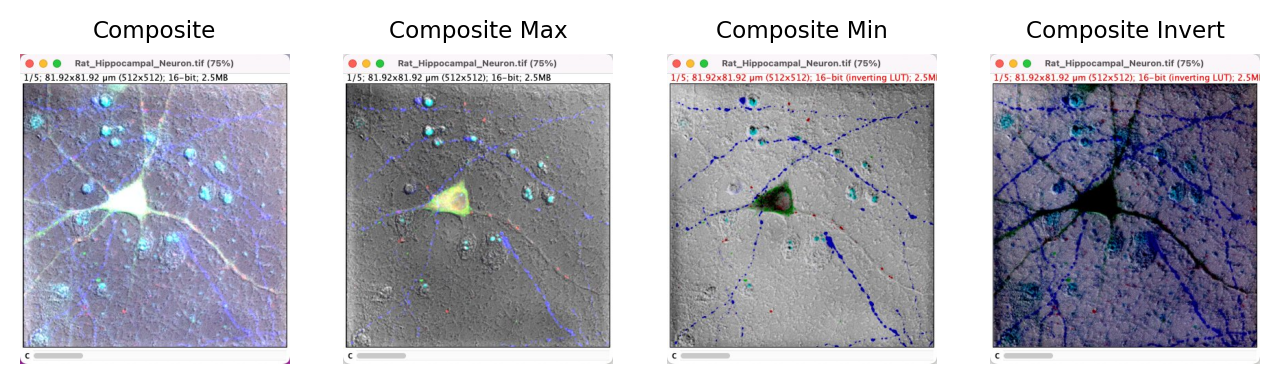

In [4]:
fig = create_figure(figsize=(8, 4))
show_image('images/composite_neuron_default.jpg', title='Composite', pos=141)
show_image('images/composite_neuron_max.jpg', title='Composite Max', pos=142)
show_image('images/composite_neuron_min.jpg', title='Composite Min', pos=143)
show_image('images/composite_neuron_invert.jpg', title='Composite Invert', pos=144)
glue_fig('fig_color_composite_new', fig)

```{glue:figure} fig_color_composite_new
---
align: center
name: fig-fiji_composite_new
---

Visualizing the new composite modes.
```

:::{admonition} Be careful with composites!
:class: danger

Any new visualization modes have the potential to cause confusion or to be abused.
Although the new composite modes can be useful, I advise caution.

The original {guilabel}`Composite` mode is really well established, and is the default.
If you use any of the 'new' composite modes in a figure for publication, you should clearly specify which.
:::


````{margin}
```{image} images/fluorescent_cells_orig_crop.jpg
````

````{margin}
```{image} images/fluorescent_cells_cb_crop.jpg
````

:::{admonition} Choosing channel colors
:class: info

By changing the LUTs, channels can be assigned any color you like. Although red/green images are widespread, especially for colocalization, they are particularly unhelpful for colorblindness.
More accessible images can be created by switching the LUTs of at least one channel to something more suitable (e.g.
Red &rarr; Magenta) – although displaying both channels separately is better still.

You can also test the effects of different colors using the Fiji command {menuselection}`Image --> Color --> Simulate Color Blindness` (note that this may require converting the image to RGB first).

More information about generating figures with suitable colors is available at <https://www.nature.com/articles/nmeth.1618>.
:::

(sec_imagej_flatten)=
## Converting to RGB

As described in {ref}`chap_colors`, one of the most important uses of RGB images is to create a compatible image for display in different software.
We will see more about how to save such images in {ref}`chap_files`.

It should be possible to convert any image to RGB using {menuselection}`Image --> Type --> RGB Color`.
However, my preferred way to create an RGB image for display is usually {menuselection}`Image --> Overlay --> Flatten` {kbd}`Shift+F`.
This not only converts the image, but also incorporates any ROIs or overlays into the RGB version.
Flattening is similar to taking a screenshot of the image as it currently appears, except unaffected by the current zoom level or field of view.

````{tab-set}

```{tab-item} Question


ImageJ has two different copying commands, {menuselection}`Edit --> Copy` and {menuselection}`Edit --> Copy to System`.
Why?

**Note:** When investigating this, you should explore {menuselection}`Edit --> Paste`, alongside two commands in the {menuselection}`File --> New -->` submenu.
Be on the lookout for any conversions.
```


```{tab-item} Answer

{menuselection}`Edit --> Copy` allows you to copy part of an individual image slice (i.e. a 2D part of a particular color channel) and paste it into another image while exactly preserving the original image type and pixel values.
You can also use {menuselection}`File --> New --> Internal Clipboard` to get the copied region (but {menuselection}`Image --> Duplicate...` is usually a better option).
However, this image type might well not be compatible with other software, therefore images copied in this way cannot be accessed outside ImageJ.

{menuselection}`Edit --> Copy to System` is needed if you want to copy an image to the system clipboard so that it can be pasted into other software.
However, be warned that this converts the image to RGB in the process.
If therefore preserves the image appearance, but not necessarily the pixel values.

```

````

````{tab-set}

```{tab-item} Practical


You can test the compatibility of composite and RGB images by opening {menuselection}`File --> Open Samples --> HeLa Cells` image, and saving it using {menuselection}`File --> Save As --> Tiff...` both before and after running {menuselection}`Image --> Type --> RGB Color` to convert the original 16-bit composite data to RGB.

Try then opening both saved images in other software (e.g. Microsoft PowerPoint&reg;) and compare their appearance.

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/open-in-imagej-js-badge.svg)](https://ij.imjoy.io/?run=https://gist.github.com/petebankhead/a45e4eed3a90b6374ec7b272db090ec9)
```

````

````{tab-set}

```{tab-item} Practical


Think of at least 2 ways in which converting a composite image to RGB can lose information.

You can explore this by comparing the images *Neuron-composite.tif* and
*Neuron-RGB.tif*.
The {menuselection}`Image --> Color --> Split Channels` command should help.

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/open-in-imagej-js-badge.svg)](https://ij.imjoy.io/?open=https://github.com/bioimagebook/practical-data/blob/main/images/Neuron-composite.tif&open=https://github.com/bioimagebook/practical-data/blob/main/images/Neuron-RGB.tif)
```


```{tab-item} Solution

+++

One way that converting an image to RGB can lose information is if the original data is 16-bit before conversion and 8-bit afterwards, causing rounding and/or clipping to occur (see {ref}`chap_bit_depths`).

Another is that during conversion the channels have been forced to be purely red, green and blue.
But perhaps they were not originally so, and separate channels have been merged into the same ones.
If you had started with more than three channels, this will definitely have occurred, but even if you had fewer channels you can have problems (like in the *Neuron_composite.tif* and *Neuron_RGB.tif* examples).

The trouble with _only_ having an RGB image is that it is no longer possible to know for sure what the original data looked like, to be able to figure out whether anything has been lost.
For example, perhaps you have managed to generate a magnificent image consisting of turquoise, yellow and dazzling pink channels.
Each pixel is displayed on screen as a combination of those colors.
However, precisely the same color for any pixel can also be represented -- rather more simply -- as a mixture of red, green and blue.
So no matter what channels and colors you began with, the final result after merging can be replicated using red, green and blue channels.
But if you _only_ have the RGB version, you might never be able to extract the original 3 channels again.
Their colors could be so mixed together that the original pixel values would be irretrievably lost.

And so the good things about RGB images are that they look identical to the original image you had before conversion, and other software (e.g. webbrowsers or PowerPoint&reg;) can understand them effortlessly.
But the _potentially very bad_ thing about RGB images is that creating them requires conversion, and after this it might very well be _impossible_ to regain the original pixel values.
```

````

--------

(sec_colors_converts)=
:::{admonition} How RGB images are converted / How I find out what I can't remember

When describing how {menuselection}`Analyze --> Measure` handles RGB image, I said that it converts the image first.

'Converts the image' is a fairly vague statement for a very good reason: I only have a vague awareness of how it works, because I've never needed to know it.
RGB images aren't good for quantification anyway, so I don't often have any reason to measure pixel values within them.

I admit this to give reassurance that there's a good chance you don't need to know it either.
So if you find the rest of this box confusing, don't worry.

**However,** it also gives an opportunity to make a bigger point: there are too many intricacies within ImageJ to remember all of them.
And that's fine.
I believe that a far more important skill is knowing how to investigate what is happening.

And so here is how I set about understanding what 'converts the image' means.

Firstly, I created an RGB image with 50x50 pixels known values for red (0), green (100) and blue (200).

<img src="images/blue.png" align=center />

**If** the conversion is simply averaging the red, green and blue values then I would expect the result of running {menuselection}`Analyze --> Measure` to be 100 (since that is the mean of 0, 100 and 200).
When I tested it, I found that was the case.
I tried some other values, and they all behaved the same way: it appears that conversion is simply averaging the channels.

I then hypothesised that I should get the same thing if I use {menuselection}`Image --> Type --> 8-bit`.
So I tried that out, and again it matched expectations.

So I concluded that {menuselection}`Analyze --> Measure` was quietly calling {menuselection}`Image --> Type --> 8-bit` on a copy of the image, and then measuring *that*.

Or maybe it's calling {menuselection}`Image --> Type --> 32-bit` instead?

I needed a new image that would show the effects of rounding, so I added 1 to the blue channel, making its values 201.

<img src="images/blue2.png" align=center />

I then tried {menuselection}`Image --> Type --> 32-bit`, which gave the expected average of 100.33.
But {menuselection}`Image --> Type --> 8-bit` still gave 100 per pixel -- because it is limited to integers.
And {menuselection}`Analyze --> Measure` also gave me 100 -- which suggest that it converts the RGB images to 8-bit, not floating point, when making its measurements.

Finally, I remembered that ImageJ sometimes sneaks in extra options.
So I opened {menuselection}`Edit --> Options --> Conversions...` and found a checkbox for {menuselection}`Weighted RGB conversion`.
If I selected it, and repeated the steps above I got quite different answers -- because it no longer converts using a straight 'average of the 3 channels'.
Rather, each channel is weighted: 0.30 x Red + 0.59 x Green + 0.11 x Blue.

Pondering the weights took me down a googling rabbit hole to see these are (somewhat) standard weight values for grayscale image conversion used across different software.
But, more importantly, I saw that the {menuselection}`Weighted RGB conversion` option affected *both* measurement and conversion -- supporting my suspicion that they are connected.

Confused?
Me too.

**But** my main point is that mortals like me can't predict what software is going to do.
Even if we think we know, there's a chance some sneaky option somewhere is changing the behavior.

What we *can* do is foster a critical mind.
We can learn enough about the software to know how to test what it is doing.

And that, at least, is how I learned to use ImageJ and came to write this book.

:::